목적 : TESLA의 주식 시세 예측

In [ ]:
# 데이터 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset_filepath = '/content/drive/MyDrive/AIFFEL/[E-04]/data_sets/TESLA.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-26,650.969971,668.200012,647.109985,657.619995,657.619995,25336600
1,2021-07-27,663.400024,666.500000,627.239990,644.780029,644.780029,32813300
2,2021-07-28,647.000000,654.969971,639.400024,646.979980,646.979980,16006600
3,2021-07-29,649.789978,683.690002,648.799988,677.349976,677.349976,30394600
4,2021-07-30,671.760010,697.530029,669.000000,687.200012,687.200012,29656400


In [ ]:
#시계열 데이터 준비
# Time Series 생성

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-07-26    657.619995
2021-07-27    644.780029
2021-07-28    646.979980
2021-07-29    677.349976
2021-07-30    687.200012
Name: Close, dtype: float64

In [ ]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

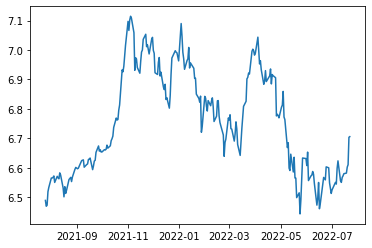

In [ ]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [ ]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


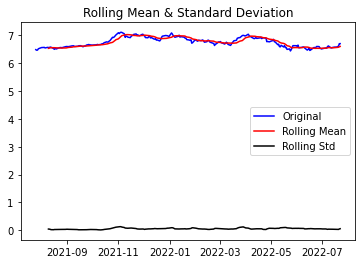

In [ ]:
# 시각화 확인
plot_rolling_statistics(ts_log, window=12)

In [ ]:
# Augmented Dickey-Fuller Test(ADF Test) 를 사용해 시계열 데이터의 안정성(stationary)을 테스트
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [ ]:
# 안정성 확인
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.903388
p-value                          0.330469
#Lags Used                      10.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


In [ ]:
# 밑에서 에러 뜸. 업데이트 진행
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


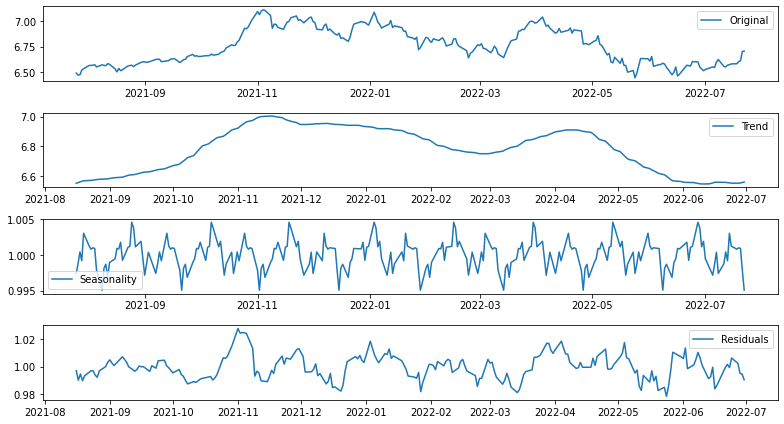

In [ ]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.495261
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


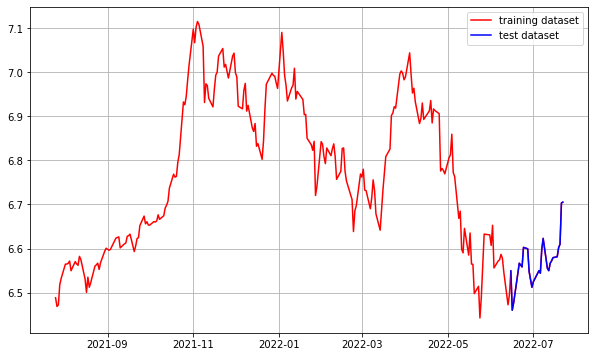

In [ ]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


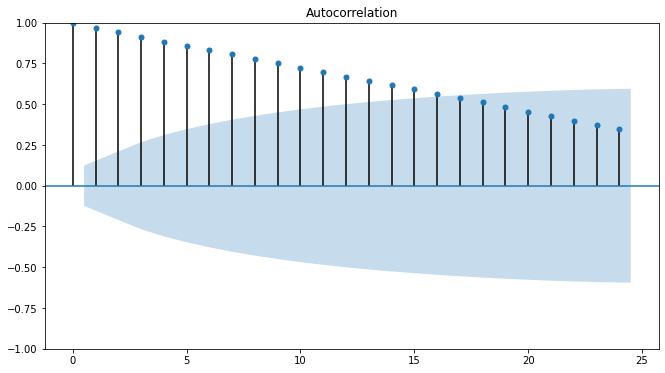

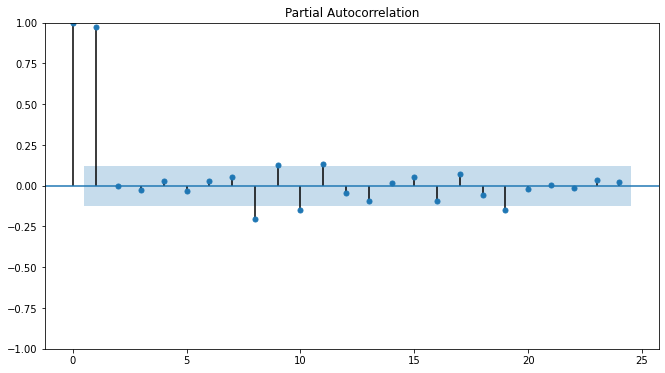

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

p = 16, 17

d = 1

Results of Dickey-Fuller Test:
Test Statistic                  -4.973561
p-value                          0.000025
#Lags Used                       9.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


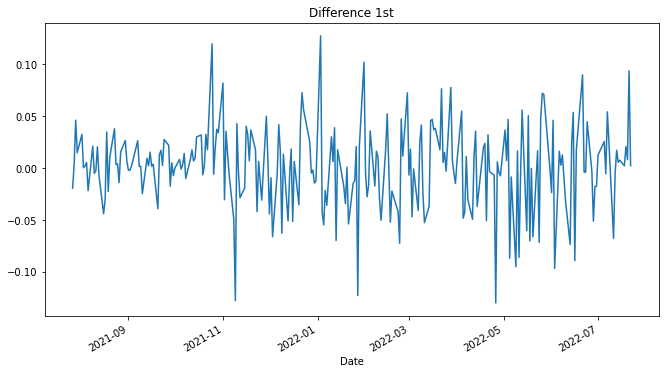

In [ ]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.742737e+00
p-value                        3.089282e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


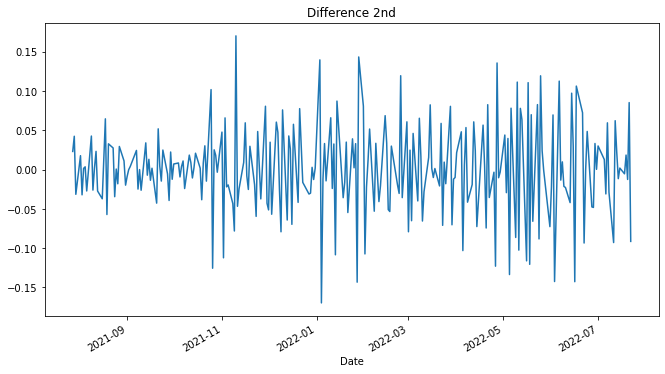

In [ ]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d = 1, 2

In [ ]:
# ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(16, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(16, 1, 2)   Log Likelihood                 418.700
Date:                Wed, 27 Jul 2022   AIC                           -799.400
Time:                        09:17:05   BIC                           -734.578
Sample:                             0   HQIC                          -773.235
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2752      0.423     -0.651      0.515      -1.104       0.554
ar.L2         -0.4478      0.392     -1.143      0.253      -1.215       0.320
ar.L3         -0.0221      0.095     -0.232      0.8

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


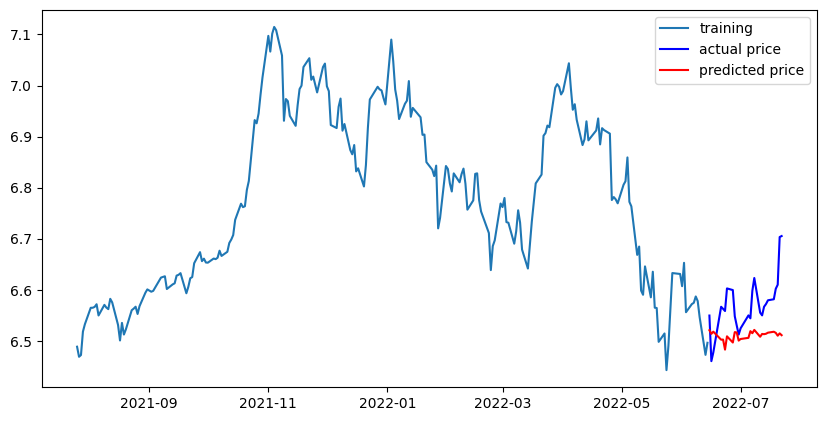

In [ ]:
# 모델 테스트 및 플로팅
## Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

## Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

## Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3329.6891929230064
MAE:  47.196727115722595
RMSE:  57.70345910708479
MAPE: 6.41%


- 진행과정
  - APPLE 데이터와 달리 시계열 데이터를 안정적으로 만드는 방법으로 시계열 데이터 분해 선택.
  - seasonal_decompose에서 계속해서 오류 발생.
  - LMS 그대로 따라했는데 에러 발생.
  - APPLE 데이터 할 때와 마찬가지로 statsmodels 버전 오류. 업데이트 진행.
  - (p, q, d) 값 = (16, 1, 1), (16, 1, 2), (17, 1, 1), (17, 1, 2)
  - (16, 1, 1) = 6.58%
  - (16, 1, 2) = 6.41%
  - (17, 1, 1) = 7.18%
  - (17, 1, 2) = 6.67%
  - (16, 1, 2)가 MAPE 6.41%로 가장 낮음. 

- 회고
  - LMS와 코랩 간의 버전 문제 때문에 에러가 많이 뜸.
  - p, q, d 값을 각각 구하는 건 줄 알았는데 p와 q가 서로 연관이 있어서 일반적으론 p나 q 중 하나의 값만 쓴다는 걸 알았음.
  - 근데 여기선 그래프를 이해하기 위해 다 씀.
